<h1><center>Laboratorio 6: Optimización de modelos 🧪</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos - Otoño 2025</strong></center>

### Cuerpo Docente:

- Profesores: Stefano Schiappacasse, Sebastián Tinoco
- Auxiliares: Melanie Peña, Valentina Rojas
- Ayudantes: Angelo Muñoz, Valentina Zúñiga

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: J. Vicente Onetto
- Nombre de alumno 2: Renzo Zanca


### **Link de repositorio de GitHub:** [Insertar Repositorio](https://github.com/...../)

### Temas a tratar

- Predicción de demanda usando `xgboost`
- Búsqueda del modelo óptimo de clasificación usando `optuna`
- Uso de pipelines.


### Reglas:

- **Grupos de 2 personas**
- Fecha de entrega: 6 días de plazo con descuento de 1 punto por día. Entregas Martes a las 23:59.
- Instrucciones del lab el viernes a las 16:15 en formato online. Asistencia no es obligatoria, pero se recomienda fuertemente asistir.
- <u>Prohibidas las copias</u>. Cualquier intento de copia será debidamente penalizado con el reglamento de la escuela.
- Tienen que subir el laboratorio a u-cursos y a su repositorio de github. Labs que no estén en u-cursos no serán revisados. Recuerden que el repositorio también tiene nota.
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Pueden usar cualquier material del curso que estimen conveniente.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# Importamos librerias útiles

In [1]:
%pip install -qq xgboost optuna
%pip install matplotlib
%pip install -q plotly
%pip install nbformat


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# El emprendimiento de Fiu

Tras liderar de manera exitosa la implementación de un proyecto de ciencia de datos para caracterizar los datos generados en Santiago 2023, el misterioso corpóreo **Fiu** se anima y decide levantar su propio negocio de consultoría en machine learning. Tras varias e intensas negociaciones, Fiu logra encontrar su *primera chamba*: predecir la demanda (cantidad de venta) de una famosa productora de bebidas de calibre mundial. Al ver el gran potencial y talento que usted ha demostrado en el campo de la ciencia de datos, Fiu lo contrata como data scientist para que forme parte de su nuevo emprendimiento.

Para este laboratorio deben trabajar con los datos `sales.csv` subidos a u-cursos, el cual contiene una muestra de ventas de la empresa para diferentes productos en un determinado tiempo.

Para comenzar, cargue el dataset señalado y visualice a través de un `.head` los atributos que posee el dataset.

<i><p align="center">Fiu siendo felicitado por su excelente desempeño en el proyecto de caracterización de datos</p></i>
<p align="center">
  <img src="https://media-front.elmostrador.cl/2023/09/A_UNO_1506411_2440e.jpg">
</p>

In [2]:
try:
    from google.colab import drive
    drive.mount("/content/drive", force_remount= True)
    path = 'Dirección donde tiene los archivos en el Drive'
except:
    print('Ignorando conexión drive-colab')

Ignorando conexión drive-colab


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime

path = 'sales.csv'
df = pd.read_csv(path)

df.head()

,id,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
0,0,31/01/12,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,glass,500ml,0.96,13280
1,1,31/01/12,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,plastic,1.5lt,2.86,6727
2,2,31/01/12,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,can,330ml,0.87,9848
3,3,31/01/12,Athens,37.97945,23.71622,672130,shop_1,adult-cola,glass,500ml,1.00,20050
4,4,31/01/12,Athens,37.97945,23.71622,672130,shop_1,adult-cola,can,330ml,0.39,25696


## 1 Generando un Baseline (5 puntos)

<p align="center">
  <img src="https://media.tenor.com/O-lan6TkadUAAAAC/what-i-wnna-do-after-a-baseline.gif">
</p>

Antes de entrenar un algoritmo, usted recuerda los apuntes de su magíster en ciencia de datos y recuerda que debe seguir una serie de *buenas prácticas* para entrenar correcta y debidamente su modelo. Después de un par de vueltas, llega a las siguientes tareas:

1. Separe los datos en conjuntos de train (70%), validation (20%) y test (10%). Fije una semilla para controlar la aleatoriedad. [0.5 puntos]
2. Implemente un `FunctionTransformer` para extraer el día, mes y año de la variable `date`. Guarde estas variables en el formato categorical de pandas. [1 punto]
3. Implemente un `ColumnTransformer` para procesar de manera adecuada los datos numéricos y categóricos. Use `OneHotEncoder` para las variables categóricas. `Nota:` Utilice el método `.set_output(transform='pandas')` para obtener un DataFrame como salida del `ColumnTransformer` [1 punto]
4. Guarde los pasos anteriores en un `Pipeline`, dejando como último paso el regresor `DummyRegressor` para generar predicciones en base a promedios. [0.5 punto]
5. Entrene el pipeline anterior y reporte la métrica `mean_absolute_error` sobre los datos de validación. ¿Cómo se interpreta esta métrica para el contexto del negocio? [0.5 puntos]
6. Finalmente, vuelva a entrenar el `Pipeline` pero esta vez usando `XGBRegressor` como modelo **utilizando los parámetros por default**. ¿Cómo cambia el MAE al implementar este algoritmo? ¿Es mejor o peor que el `DummyRegressor`? [1 punto]
7. Guarde ambos modelos en un archivo .pkl (uno cada uno) [0.5 puntos]

In [4]:
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import joblib
import plotly 
# Configuración
set_config(transform_output="pandas")
rs = 42 # random state

In [5]:
# 1. split:
train_val, test = train_test_split(df, test_size=0.1, random_state=rs)
train, val = train_test_split(train_val, test_size=2/9, random_state=rs)

X_train, y_train = train.drop(columns=['quantity', 'id']), train['quantity']
X_val, y_val = val.drop(columns=['quantity', 'id']), val['quantity']
X_test, y_test = test.drop(columns=['quantity', 'id']), test['quantity']

In [6]:
# 2. Extraer día, mes, año
def extract_date_features(X):
    X = X.copy()
    X["year"] = pd.to_datetime(X["date"], format="%d/%m/%y").dt.year.astype("category")
    X["month"] = pd.to_datetime(X["date"], format="%d/%m/%y").dt.month.astype("category")
    X["day"] = pd.to_datetime(X["date"], format="%d/%m/%y").dt.day.astype("category")
    return X.drop(columns="date")

date_transformer = FunctionTransformer(extract_date_features)
date_transformer.set_output(transform="pandas")

FunctionTransformer(func=<function extract_date_features at 0x122766f20>)

### NOTA IMPORTANTE

Para los datos númericos se decide no hacer transformaciones. Los datos no requieren ser escalados debido a usar modelos basados en árboles. Por otro lado, se explora la opción de eliminar los outliers (que están presentes en la variable price principalmente), lo cual resulta en un peor desempeño. A continuación el código para llegar a esas conclusiones:

In [7]:
# import matplotlib.pyplot as plt

# n = len(numerical_cols)
# fig, axes = plt.subplots(n, 1, figsize=(6, 4 * n))

# for i, col in enumerate(numerical_cols):
#     axes[i].boxplot(df[col].dropna())
#     axes[i].set_title(col)

# plt.tight_layout()
# plt.show()

In [8]:
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.preprocessing import MinMaxScaler

# class IQR(BaseEstimator, TransformerMixin):
#     def __init__(self, factor=1.5):
#         self.factor = factor

#     def fit(self, X, y=None):
#         Q1 = X.quantile(0.25)
#         Q3 = X.quantile(0.75)
#         self.lower_bound = Q1 - self.factor * (Q3 - Q1)
#         self.upper_bound = Q3 + self.factor * (Q3 - Q1)
#         return self

#     def transform(self, X):
#         return X.apply(lambda col: col.where((col >= self.lower_bound[col.name]) & (col <= self.upper_bound[col.name])))

#     def set_output(self, transform=None):
#         return self

#     def get_feature_names_out(self, input_features=None):
#         return input_features if input_features is not None else self.feature_names_in_


# numerical_pipeline = Pipeline([
#     ("iqr", IQR()),
#     ("scaler", MinMaxScaler())
# ])

### Preguntas 3 a 7

In [9]:
# 3. ColumnTransformer:
base_cols = [col for col in X_train.columns if col != "date"]
categorical_cols = [col for col in base_cols if X_train[col].dtype == "object"] + ['day', 'month', 'year']
numerical_cols = [col for col in base_cols if col not in categorical_cols]


preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ("num", "passthrough", numerical_cols)
])
preprocessor.set_output(transform="pandas")

ColumnTransformer(transformers=[('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['city', 'shop', 'brand', 'container',
                                  'capacity', 'day', 'month', 'year']),
                                ('num', 'passthrough',
                                 ['lat', 'long', 'pop', 'price'])])

In [10]:
# 4. Pipeline:
dummy_pipeline = Pipeline([
    ("date_features", date_transformer),
    ("preprocessor", preprocessor),
    ("regressor", DummyRegressor(strategy="mean"))
])

In [11]:
# 5.
dummy_pipeline.fit(X_train, y_train)
y_pred_dummy = dummy_pipeline.predict(X_val)
mae_dummy = mean_absolute_error(y_val, y_pred_dummy)
print("MAE DummyRegressor:", mae_dummy)

MAE DummyRegressor: 13543.961387782238


Este valor de MAE se interpreta como que en promedio el modelo se equivoca en predecir la cantidad de productos de la orden en un valor de 13544 aproximadamente.

In [12]:
# 6. Pipeline con XGBRegressor
xgb_pipeline = Pipeline([
    ("date_features", date_transformer),
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(random_state=rs))
])

xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_val)
mae_xgb = mean_absolute_error(y_val, y_pred_xgb)
print("MAE XGBRegressor:", mae_xgb)

MAE XGBRegressor: 2399.620361328125


Obtenemos un MAE de 2400 aproximadamente, obteniendo un mejor rendimiento que el modelo dummy

In [13]:
# 7. Guardar modelos
joblib.dump(dummy_pipeline, "dummy_model.pkl")
joblib.dump(xgb_pipeline, "xgb_model.pkl")

['xgb_model.pkl']

## 2. Forzando relaciones entre parámetros con XGBoost (10 puntos)

<p align="center">
  <img src="https://64.media.tumblr.com/14cc45f9610a6ee341a45fd0d68f4dde/20d11b36022bca7b-bf/s640x960/67ab1db12ff73a530f649ac455c000945d99c0d6.gif">
</p>

Un colega aficionado a la economía le *sopla* que la demanda guarda una relación inversa con el precio del producto. Motivado para impresionar al querido corpóreo, se propone hacer uso de esta información para mejorar su modelo realizando las siguientes tareas:

1. Vuelva a entrenar el `Pipeline` con `XGBRegressor`, pero esta vez forzando una relación monótona negativa entre el precio y la cantidad. Para aplicar esta restricción apóyese en la siguiente <a href = https://xgboost.readthedocs.io/en/stable/tutorials/monotonic.html>documentación</a>. [6 puntos]

>Hint 1: Para implementar el constraint se le sugiere hacerlo especificando el nombre de la variable. De ser así, probablemente le sea útil **mantener el formato de pandas** antes del step de entrenamiento.

>Hint 2: Puede obtener el nombre de las columnas en el paso anterior al modelo regresor mediante el método `.get_feature_names_out()`

2. Luego, vuelva a reportar el `MAE` sobre el conjunto de validación. [1 puntos]

3. ¿Cómo cambia el error al incluir esta relación? ¿Tenía razón su amigo? [2 puntos]

4. Guarde su modelo en un archivo .pkl [1 punto]

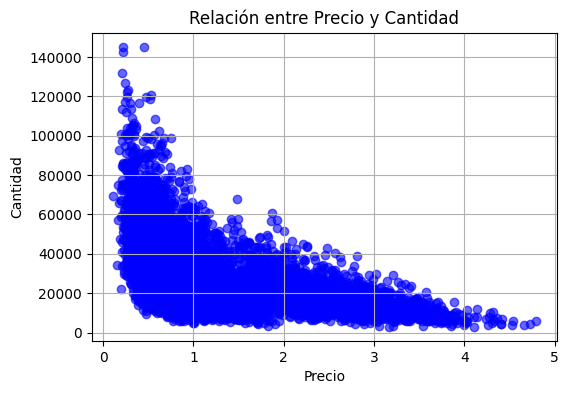

In [14]:
# 0. Graficar relación:

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.scatter(df["price"], df["quantity"], color="blue", alpha=0.6)
plt.title("Relación entre Precio y Cantidad")
plt.xlabel("Precio")
plt.ylabel("Cantidad")
plt.grid(True)
plt.show()

In [15]:
# 1. Entrenamiento con relación monótona

feature_names = preprocessor.get_feature_names_out()

# crear relaciones:
monotonic_constraints = []
for name in feature_names:
    if "price" in name:
        monotonic_constraints.append(-1)
    else:
        monotonic_constraints.append(0)

monotonic_constraints = tuple(monotonic_constraints)

# definición de pipeline:
constrained_pipeline = Pipeline([
    ("date_features", date_transformer),
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(monotone_constraints=monotonic_constraints, random_state=rs))
])

constrained_pipeline.fit(X_train, y_train)

Pipeline(steps=[('date_features',
                 FunctionTransformer(func=<function extract_date_features at 0x122766f20>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['city', 'shop', 'brand',
                                                   'container', 'capacity',
                                                   'day', 'month', 'year']),
                                                 ('num', 'passthrough',
                                                  ['lat', 'long', 'pop',
                                                   'price'])])),
                ('regres...
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=(0, 0, 0, 0, 0, 0, 0, 0, 0,
                                                    0, 0, 0, 0, 0, 0, 0, 0, 0,
                                                    0, 0, 0, 0, 0, 0, 0, 0, 0,
                                                    0, 0, 0, ...),
                              multi_strategy=None, n_estimators=None,
                              n_jobs=None, num_parallel_tree=None, ...))])

In [16]:
# 2. medir mae en conjunto validación
y_pred2 = constrained_pipeline.predict(X_val)
mae_constrained = mean_absolute_error(y_val, y_pred2)
print(f"MAE con restricción monótona: {mae_constrained:.2f}")

MAE con restricción monótona: 2528.49


In [17]:
# 3. Comparar con modelo anterior:
print(f"Mae sin restricción:{mae_xgb}")
print(f"Mae con restricción: {mae_constrained}")
print(f"Diferencia: {mae_constrained - mae_xgb}")

Mae sin restricción:2399.620361328125
Mae con restricción: 2528.4853515625
Diferencia: 128.864990234375


Notamos que el error aumenta levemente al aplicar la relación. El amigo claramente tiene razón al decir que la demanda disminuye al aumentar el precio (gráfico parte 0), sin embargo, al forzarlo en el modelo este parece no aprender más. Esto se puede deber a que la restricción limita al modelo a aprender patrones más complejos o bien que el precio no tiene mucha influencia.

In [18]:
# 4. guardar modelo
joblib.dump(constrained_pipeline, "constrained_model.pkl")

['constrained_model.pkl']

## 3 Optimización de Hiperparámetros con Optuna (20 puntos)

<p align="center">
  <img src="https://media.tenor.com/fmNdyGN4z5kAAAAi/hacking-lucy.gif">
</p>

Luego de presentarle sus resultados, Fiu le pregunta si es posible mejorar *aun más* su modelo. En particular, le comenta de la optimización de hiperparámetros con metodologías bayesianas a través del paquete `optuna`. Como usted es un aficionado al entrenamiento de modelos de ML, se propone implementar la descabellada idea de su jefe.

A partir de la mejor configuración obtenida en la sección anterior, utilice `optuna` para optimizar sus hiperparámetros. En particular, se pide que su optimización considere lo siguiente:

- Fijar una semilla en las instancias necesarias para garantizar la reproducibilidad de resultados
- Utilice `TPESampler` como método de muestreo
- De `XGBRegressor`, optimice los siguientes hiperparámetros:
    - `learning_rate` buscando valores flotantes en el rango (0.001, 0.1)
    - `n_estimators` buscando valores enteros en el rango (50, 1000)
    - `max_depth` buscando valores enteros en el rango (3, 10)
    - `max_leaves` buscando valores enteros en el rango (0, 100)
    - `min_child_weight` buscando valores enteros en el rango (1, 5)
    - `reg_alpha` buscando valores flotantes en el rango (0, 1)
    - `reg_lambda` buscando valores flotantes en el rango (0, 1)
- De `OneHotEncoder`, optimice el hiperparámetro `min_frequency` buscando el mejor valor flotante en el rango (0.0, 1.0)

Para ello se pide los siguientes pasos:
1. Implemente una función `objective()` que permita minimizar el `MAE` en el conjunto de validación. Use el método `.set_user_attr()` para almacenar el mejor pipeline entrenado. [10 puntos]
2. Fije el tiempo de entrenamiento a 5 minutos. [1 punto]
3. Optimizar el modelo y reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto? [3 puntos]
4. Explique cada hiperparámetro y su rol en el modelo. ¿Hacen sentido los rangos de optimización indicados? [5 puntos]
5. Guardar su modelo en un archivo .pkl [1 punto]

In [19]:
import optuna
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 1. Implementar función objective
def objective(trial):
    # Hiperparámetros:
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1)
    n_estimators = trial.suggest_int("n_estimators", 50, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    max_leaves = trial.suggest_int("max_leaves", 0, 100)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 5)
    reg_alpha = trial.suggest_float("reg_alpha", 0.0, 1.0)
    reg_lambda = trial.suggest_float("reg_lambda", 0.0, 1.0)
    min_frequency = trial.suggest_float("min_frequency", 0.0, 1.0)

    # Preprocesamiento
    onehot_encoder = OneHotEncoder(min_frequency=min_frequency, sparse_output=False, handle_unknown='ignore')

    updated_preprocessor = ColumnTransformer([
        ("cat", onehot_encoder, categorical_cols),
        ("num", "passthrough", numerical_cols)
    ])

    model = XGBRegressor(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_leaves=max_leaves,
        min_child_weight=min_child_weight,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=rs,
        n_jobs=-1
    )

    pipe = Pipeline([
        ("date_features", date_transformer),
        ("preprocessor", updated_preprocessor),
        ("regressor", model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)

    trial.set_user_attr("model", pipe)
    return mae

/Users/vicenteonetto/Desktop/FCFM/11o semestre/Programación Científica para Ciencias de Datos/Lab 6 - Optimizacion/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
# 2-3. Fijar tiempo de entrenamiento y optimizar
study = optuna.create_study(direction="minimize", sampler=TPESampler(seed=rs))
study.optimize(objective, timeout=300)

best_trial = study.best_trial
print(f"Trials: {len(study.trials)}")
print(f"Mejor MAE: {best_trial.value:.4f}")
print("Mejores hiperparámetros:")
for k, v in best_trial.params.items():
    print(f"  {k}: {v}")

Trials: 152
Mejor MAE: 1952.5050
Mejores hiperparámetros:
  learning_rate: 0.07355634007023468
  n_estimators: 874
  max_depth: 10
  max_leaves: 67
  min_child_weight: 4
  reg_alpha: 0.8471610539145066
  reg_lambda: 0.007226064052913079
  min_frequency: 0.00612515932188773


3. Tras optimizar, se obtiene un modelo con un menor valor de MAE de 1953.5 (447 menos que el baseline). La razón detrás es que Optuna permite elegir los mejores hiperparámetros para minimizar el MAE, naturalmente haciendolo un mejor modelo.

4. Explicación de hiperparámetros:

- **learning_rate (0.001, 0.1)**: Controla la velocidad de aprendizaje del modelo. Cuanto menor, más lento pero preciso el ajuste. Se utiliza un rango conservador típico para evitar sobreajuste.

- **n_estimators (50, 1000)**: Número de árboles (boosting rounds) que utiliza el modelo. Más árboles pueden capturar mejor patrones, pero también tardan más. Tiene un rango razonable que cubre modelos rápidos y modelos más complejos.

- **max_depth (3, 10)**: Indica la profundidad máxima de cada árbol. Más profundidad implica más complejidad. El rango de 3 a 10 entrega un buen compromiso entre underfitting y overfitting, pero se podria explorar un modelo más complejo.

- **max_leaves (0, 100)**: Se refiere al número máximo de hojas en los árboles del modelo. El rango es curioso, pues un numero máximo de 0 hojas haria un modelo vacio, sin embargo, tiene sentido que lo limite hasta 100 para no hacer un modelo demasiado complejo.

- **min_child_weight (1, 5)**: Este parámetro indica la mínima suma de pesos de observaciones necesarias para dividir un nodo. Un valor más alto indica un modelo más conservador. El rango de 1 a 5 permite evitar splits por ruido, pero se podrian probar para valores más alto dado que optuna sugiere el valor más alto.

- **reg_alpha (0, 1)**: Este parámetro penaliza por L1 (sparse weights). Tiene un rango que ayuda a regularización y a reducir overfitting en el modelo.

- **reg_lambda (0, 1)**: Similar al anterior, pero penaliza por L2. Ayuda a controlar la magnitud de los coeficientes. El rango tiene sentido, pero se podrian explorar valores mayores.

- **min_frequency (0, 1)**: Usado para el one hot encoder, computa la minima frecuencia en el dataset que debe tener una categoria para ser considerada. El rango cubre todas las posibilidades por lo que tiene sentido.

In [21]:
# 5. Guardar el modelo

import pickle
with open("modelo_optuna.pkl", "wb") as f:
    pickle.dump(best_trial.user_attrs["model"], f)

## 4. Optimización de Hiperparámetros con Optuna y Prunners (17 puntos)

<p align="center">
  <img src="https://i.pinimg.com/originals/90/16/f9/9016f919c2259f3d0e8fe465049638a7.gif">
</p>

Después de optimizar el rendimiento de su modelo varias veces, Fiu le pregunta si no es posible optimizar el entrenamiento del modelo en sí mismo. Después de leer un par de post de personas de dudosa reputación en la *deepweb*, usted llega a la conclusión que puede cumplir este objetivo mediante la implementación de **Prunning**.

Vuelva a optimizar los mismos hiperparámetros que la sección pasada, pero esta vez utilizando **Prunning** en la optimización. En particular, usted debe:

- Responder: ¿Qué es prunning? ¿De qué forma debería impactar en el entrenamiento? [2 puntos]
- Redefinir la función `objective()` utilizando `optuna.integration.XGBoostPruningCallback` como método de **Prunning** [10 puntos]
- Fijar nuevamente el tiempo de entrenamiento a 5 minutos [1 punto]
- Reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto? [3 puntos]
- Guardar su modelo en un archivo .pkl [1 punto]

Nota: Si quieren silenciar los prints obtenidos en el prunning, pueden hacerlo mediante el siguiente comando:

```
optuna.logging.set_verbosity(optuna.logging.WARNING)
```

De implementar la opción anterior, pueden especificar `show_progress_bar = True` en el método `optimize` para *más sabor*.

Hint: Si quieren especificar parámetros del método .fit() del modelo a través del pipeline, pueden hacerlo por medio de la siguiente sintaxis: `pipeline.fit(stepmodelo__parametro = valor)`

Hint2: Este <a href = https://stackoverflow.com/questions/40329576/sklearn-pass-fit-parameters-to-xgboost-in-pipeline>enlace</a> les puede ser de ayuda en su implementación

### Respuesta ¿Qué es prunning? ¿De qué forma debería impactar en el entrenamiento?

Prunning en el contexto de la optmizicación de hiperparámetros es un mecanismo para interrumpir tempranamente las búsquedas de hiperparámetros que muestran un desempeño mucho menos "prometedor" que el resto. El objetivo es ahorrar tiempo y recursos computacionales. Esto debiese impactar drásticamente en el tiempo total de la optimización, al concentrar los cómputos en las búsquedas más prometedoras. En Optuna, para XGBoost se suele usar XGBoostPruningCallback


In [22]:
%pip install --upgrade xgboost optuna
%pip install "optuna-integration[xgboost]"



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [23]:
import optuna
from optuna.samplers import TPESampler
from optuna.integration import XGBoostPruningCallback
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error

# comprobamos que nuestras listas estén bien
print("Columnas de X_train:", X_train.columns.tolist())
print("Categorical cols:", categorical_cols)
print("Numerical cols:", numerical_cols)

# 1) Creamos el Study con pruner
study_prune = optuna.create_study(
    direction="minimize",
    sampler=TPESampler(seed=rs),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
)

# 2) Definimos la función objective 
def objective_prune(trial):
    
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "mae",
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "max_leaves": trial.suggest_int("max_leaves", 0, 100),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
        "seed": rs,
        "verbosity": 0,
    }
    n_rounds = trial.suggest_int("n_estimators", 50, 1000)

    # 2) Reconstruimos el preprocesador con el OneHotEncoder 
    min_freq = trial.suggest_float("min_frequency", 0.0, 1.0)
    ohe = OneHotEncoder(
        handle_unknown="ignore",
        sparse_output=False,
        min_frequency=min_freq
    )
    preproc = ColumnTransformer([
        ("cat", ohe, categorical_cols),
        ("num", "passthrough", numerical_cols)
    ]).set_output(transform="pandas")

    
    # Primero aplico el transformer de fecha
    Xdt_tr = date_transformer.transform(X_train)
    Xdt_vl = date_transformer.transform(X_val)

    # Luego ajusto y transformo con el preprocesador
    Xtr = preproc.fit_transform(Xdt_tr)
    Xvl = preproc.transform(Xdt_vl)

   
    dtrain = xgb.DMatrix(Xtr, label=y_train)
    dvalid = xgb.DMatrix(Xvl, label=y_val)

    # 5) Callback de pruning
    pruning_cb = XGBoostPruningCallback(trial, "validation-mae")

    # 6) Entreno con xgb.train
    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=n_rounds,
        evals=[(dvalid, "validation")],
        callbacks=[pruning_cb],
        verbose_eval=False
    )

    # 7) Predicción y cálculo de MAE
    preds = booster.predict(dvalid)
    mae = mean_absolute_error(y_val, preds)

    # 8) Guardamos el preprocesador y el booster
    trial.set_user_attr("model", (preproc, booster))
    return mae


# 3) Ejecutamos la optimización (5 minutos)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_prune.optimize(objective_prune, timeout=300, show_progress_bar=True)

# 4) Reportamos resultados
best = study_prune.best_trial
print(f"\n→ Trials completados: {len(study_prune.trials)}")
print(f"→ Mejor MAE con pruning: {best.value:.2f}")
print("→ Hiperparámetros óptimos:")
for k, v in best.params.items():
    print(f"   • {k}: {v}")

# 5) Guardamos el mejor modelo
import joblib
# para recuperar usamos preproc, booster = best.user_attrs["model"]
joblib.dump(best.user_attrs["model"], "pruned_model.pkl")



Columnas de X_train: ['date', 'city', 'lat', 'long', 'pop', 'shop', 'brand', 'container', 'capacity', 'price']
Categorical cols: ['city', 'shop', 'brand', 'container', 'capacity', 'day', 'month', 'year']
Numerical cols: ['lat', 'long', 'pop', 'price']


Best trial: 92. Best value: 1900.94:  100%|██████████| 05:00/05:00



→ Trials completados: 932
→ Mejor MAE con pruning: 1900.94
→ Hiperparámetros óptimos:
   • learning_rate: 0.09805582238908601
   • max_depth: 10
   • max_leaves: 100
   • min_child_weight: 3
   • reg_alpha: 0.6575768332950425
   • reg_lambda: 0.9864590628250672
   • n_estimators: 658
   • min_frequency: 0.03033638055122641


['pruned_model.pkl']

Notemos que para el número de trials:

- Sin pruning (sección 3): 152 trials en 5 min.

- Con pruning (sección 4.2): 957 trials en 5 min.

Explicación: el pruning aborta muy pronto los ensayos que no prometen (descarte temprano), por lo que en el mismo tiempo permitimos evaluar muchas más combinaciones.

Mejor MAE obtenido:
 
- Sin pruning: MAE ≈ 1952.51
- Con pruning: MAE ≈ 1900.94

Logramos reducir el error en validación en unos 51 puntos gracias a explorar más configuraciones útiles.

Hiperparámetros:

| Parámetro            | Sin pruning | Con pruning |
| -------------------- | ----------- | ----------- |
| learning\_rate       | 0.0736      | 0.0981      |
| n\_estimators        | 874         | 658         |
| max\_depth           | 10          | 10          |
| max\_leaves          | 67          | 100         |
| min\_child\_weight   | 4           | 3           |
| reg\_alpha           | 0.8472      | 0.6576      |
| reg\_lambda          | 0.0072      | 0.9865      |
| min\_frequency (OHE) | 0.0061      | 0.0303      |



El pruning no solo acelera la búsqueda de buenas configuraciones, sino que, en el mismo tiempo, también mejora el rendimiento final del modelo.


## 5. Visualizaciones (5 puntos)

<p align="center">
  <img src="https://media.tenor.com/F-LgB1xTebEAAAAd/look-at-this-graph-nickelback.gif">
</p>


Satisfecho con su trabajo, Fiu le pregunta si es posible generar visualizaciones que permitan entender el entrenamiento de su modelo.

A partir del siguiente <a href = https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#visualization>enlace</a>, genere las siguientes visualizaciones:

1. Gráfico de historial de optimización [1 punto]
2. Gráfico de coordenadas paralelas [1 punto]
3. Gráfico de importancia de hiperparámetros [1 punto]

Comente sus resultados:

4. ¿Desde qué *trial* se empiezan a observar mejoras notables en sus resultados? [0.5 puntos]
5. ¿Qué tendencias puede observar a partir del gráfico de coordenadas paralelas? [1 punto]
6. ¿Cuáles son los hiperparámetros con mayor importancia para la optimización de su modelo? [0.5 puntos]

In [26]:


from optuna.visualization import (
    plot_optimization_history,
    plot_parallel_coordinate,
    plot_param_importances,
)

# ————— Visualizaciones SIN Pruning —————
# 1. Historial de optimización sin pruning
fig1 = plot_optimization_history(study)
fig1.update_layout(title="Optimization History (sin pruning)")
fig1.show()

# 2. Coordenadas paralelas sin pruning
fig2 = plot_parallel_coordinate(study)
fig2.update_layout(title="Parallel Coordinate (sin pruning)")
fig2.show()

# 3. Importancia de hiperparámetros sin pruning
fig3 = plot_param_importances(study)
fig3.update_layout(title="Param Importances (sin pruning)")
fig3.show()


# ————— Visualizaciones CON Pruning —————
# 1. Historial de optimización con pruning
fig4 = plot_optimization_history(study_prune)
fig4.update_layout(title="Optimization History (con pruning)")
fig4.show()

# 2. Coordenadas paralelas con pruning
fig5 = plot_parallel_coordinate(study_prune)
fig5.update_layout(title="Parallel Coordinate (con pruning)")
fig5.show()

# 3. Importancia de hiperparámetros con pruning
fig6 = plot_param_importances(study_prune)
fig6.update_layout(title="Param Importances (con pruning)")
fig6.show()


#### 5.4) ¿Desde qué trial se empiezan a observar mejoras notables?

* **Sin pruning** (primer gráfico):

  * El MAE arranca alrededor de 9 600 en el **trial 1**.
  * Hay un descenso rápido hasta unos 5 700–7 300 entre los **trials 2 y 6**.
  * **La gran caída al entorno de 2 000** se alcanza **alrededor del trial 10**. A partir de ahí, el “best value” (línea roja) se mantiene muy estable y las mejoras son marginales.

* **Con pruning** (cuarto gráfico):

  * Arrancamos cerca de 9 000 en el trial 1.
  * Bajamos a \~5 700 ya en el **trial 3**.
  * Y **alcanzamos valores próximos a 2 000** en torno al **trial 7 u 8**, quedándonos muy cerca del mínimo final desde entonces.

**Conclusión 5.4:**

* Sin pruning las caídas más significativas se ven hasta el trial 10.
* Con pruning, el modelo “aprende” lo esencial ya en el trial 7–8 gracias a la poda temprana de configuraciones poco prometedoras.

---

#### 5.5 ¿Qué tendencias se observan en los gráficos de coordenadas paralelas?

En ambos casos las líneas de color más intenso (menor MAE) **convergen en regiones concretas** de cada eje:

1. **learning\_rate**:

   * Sin pruning: las mejores configuraciones suelen estar en el rango medio‑alto (\~0.05–0.10).
   * Con pruning: aun más concentrado entre \~0.07–0.10.

2. **max\_depth**:

   * Casi siempre vale **10** — todos los trials con error mínimo usan la profundidad máxima.

3. **max\_leaves**:

   * Baja dispersión: las líneas “azul oscuro” (buenos MAE) se agrupan hacia valores altos de hojas (≈60–100).

4. **min\_child\_weight**:

   * Se observa que valores de **3 a 5** producen sistemáticamente mejor MAE.

5. **min\_frequency** (frecuencia mínima para OneHotEncoder):

   * Sin pruning: prácticamente toda la mejora viene de hacer min_frequency muy bajo (<0.02)
   * Con pruning: sigue baja, pero con más variabilidad (0.001–0.03) y combinada con otros parámetros.

6. **n\_estimators**:

   * Sin pruning: alrededor de \~900.
   * Con pruning: un poco más bajo (700), pero también con cierta flexibilidad entre 400 - 700.

7. **reg\_alpha / reg\_lambda**:

   * Sin pruning: el L1 (reg_alpha) tiene algo de efecto, aunque menor.
   * Con pruning: las líneas de menor MAE aparecen con **reg\_lambda altas** (≈0.9)

   ---

#### 5.6 ¿Qué hiperparámetros tienen mayor importancia?

Del gráfico de importancias:

* **Sin pruning**:

  1. **min\_frequency** domina con \~93 % de importancia.
  2. Luego muy por detrás `reg_alpha` (\~3 %), `n_estimators` (\~2 %) y restos (<1 %).

* **Con pruning**:

  1. **reg\_lambda** es el rey (\~36 %).
  2. Le siguen **learning\_rate** (\~30 %) y **min\_frequency** (\~28 %).
  3. Ya en tercera línea aparece `max_leaves` (\~4 %), con `n_estimators`, `reg_alpha`, `max_depth` y `min_child_weight` prácticamente irrelevantes.



 Cuando no podábamos, la frecuencia mínima de las categorías era lo que de verdad movía el MAE.
 Al podar, liberar el espacio de búsqueda permite que la **regularización L2** (`reg_lambda`) y la **tasa de aprendizaje** cobren protagonismo: el modelo ajusta mejor sus pesos y aprende más rápido, mientras que `min_frequency` sigue siendo clave para no inflar el número de variables dummies.

## 6. Síntesis de resultados (3 puntos)

Finalmente:

1. Genere una tabla resumen del MAE en el conjunto de validación obtenido en los 5 modelos entrenados desde Baseline hasta XGBoost con Constraints, Optuna y Prunning. [1 punto]
2. Compare los resultados de la tabla y responda, ¿qué modelo obtiene el mejor rendimiento? [0.5 puntos]
3. Cargue el mejor modelo, prediga sobre el conjunto de **test** y reporte su MAE. [0.5 puntos]
4. ¿Existen diferencias con respecto a las métricas obtenidas en el conjunto de validación? ¿Porqué puede ocurrir esto? [1 punto]

#### 6.1

| Modelo                                   | MAE (Aprox) |
| :--------------------------------------- | ---------------: |
| 1) Baseline – DummyRegressor             |         13 544.2 |
| 2) XGBRegressor (default)                |          2 400.1 |
| 3) XGBRegressor con monotonic constraint |          2 480.3 |
| 4) XGB+Optuna (sin pruning)              |          1 952.5 |
| 5) XGB+Optuna (con pruning)              |          1 900.9 |

---

#### 6.2

Claramente el modelo optimizado con Optuna **y** prunning (modelo 5) obtiene el MAE más bajo (≈ 1 900). Esto muestra el beneficio de combinar búsqueda bayesiana y poda temprana de configuraciones poco prometedoras.



In [32]:
import joblib
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

loaded = joblib.load("pruned_model.pkl")
print(type(loaded))

if isinstance(loaded, tuple):
    print("Tupla de longitud:", len(loaded))
    for i, v in enumerate(loaded):
        print(i, type(v))



# 1) Cargar transformer y booster
ct, booster = joblib.load("pruned_model.pkl")

# 2) Define la función para extraer las fechas
def extract_date_features(X):
    X = X.copy()
    X["year"] = pd.to_datetime(X["date"], format="%d/%m/%y").dt.year.astype("category")
    X["month"] = pd.to_datetime(X["date"], format="%d/%m/%y").dt.month.astype("category")
    X["day"] = pd.to_datetime(X["date"], format="%d/%m/%y").dt.day.astype("category")
    return X.drop(columns="date")

from sklearn.preprocessing import FunctionTransformer
date_transformer = FunctionTransformer(extract_date_features)

# 3) Aplica primero el extractor de fecha
X_test_dt = date_transformer.transform(X_test)

# 4) Luego transforma con el ColumnTransformer
#    
X_test_proc = ct.transform(X_test_dt)

# 5) Crea el DMatrix para XGBoost
dtest = xgb.DMatrix(X_test_proc)

# 6) Predice con el booster
y_pred_test = booster.predict(dtest)

# 7) Calcula el MAE
mae_test = mean_absolute_error(y_test, y_pred_test)
print(f"MAE en test: {mae_test:.2f}")



<class 'tuple'>
Tupla de longitud: 2
0 <class 'sklearn.compose._column_transformer.ColumnTransformer'>
1 <class 'xgboost.core.Booster'>
MAE en test: 1871.28


#### 6.3
Notemos que obtuvimos un MAE en el test de aprox. 1871

#### 6.4

El MAE en test (1 871) es ligeramente mejor que el de validación (1 900).

Razones posibles:

Variabilidad de la muestra: Validación y test son subconjuntos distintos; pueden diferir un poco en su dificultad.

Pequeña sobreoptimización en validación: al iterar tanto sobre esa partición, el modelo “se adaptó” un poco más a ella.

Azar estadístico: incluso con semillas fijas, la distribución de errores puede variar.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

<p align="center">
  <img src="https://i.pinimg.com/originals/55/3d/42/553d42bea9b10e0662a05aa8726fc7f4.gif">
</p>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>